# Creating artificial clustered trajectories

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(12345)

## Functions to build trajectories

Here's a few functions that we can use to create and morph trajectories.

In [3]:
def create_smooth_traj(number_steps=100, smooth_length=11):
    window = np.hanning(smooth_length)
    window /= window.sum()
    return pd.DataFrame({
        "x": np.convolve(
            np.random.normal(size=(number_steps, )),
            window
        ).cumsum(),
        "y": np.convolve(
            np.random.normal(size=(number_steps, )),
            window
        ).cumsum(),
    }).iloc[:number_steps]

In [4]:
def create_traj_from_to(
    start_x=0, 
    start_y=0, 
    end_x=1, 
    end_y=1, 
    number_steps=100,
):
    return pd.DataFrame({
        "x": np.linspace(start_x, end_x, number_steps),
        "y": np.linspace(start_y, end_y, number_steps),
    })

In [5]:
def create_sine_waves(number_steps=100, inv_wave_number=2, stretch=1):
    return pd.Series(np.sin(np.linspace(0, (2 / inv_wave_number * np.pi) ** (1/stretch), number_steps) ** stretch))

## Simple example: Morphing a straight line from A to B

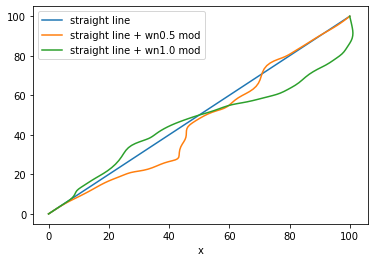

In [6]:
# Create and plot a straight line with 100 points
ax = create_traj_from_to(
    start_x=0, start_y=0, end_x=100, end_y=100, number_steps=100
).plot(
    x="x", y="y", label="straight line"
)

# add a second trajectory that modifies the first one with a wavenumber 1/2 pattern
# (ie not changing the start and end point)
(
    create_traj_from_to(
        start_x=0, start_y=0, end_x=100, end_y=100, number_steps=100
    )
    + create_smooth_traj(number_steps=100).mul(
        create_sine_waves(inv_wave_number=2, number_steps=100), axis=0
    )
).plot(
    x="x", y="y", ax=ax, label="straight line + wn0.5 mod"
)

# add a third trajectory that modifies the first one with a wavenumber 1 pattern
# (still not changing the start and end point)
(
    create_traj_from_to(
        start_x=0, start_y=0, end_x=100, end_y=100, number_steps=100
    )
    + create_smooth_traj(number_steps=100).mul(
        create_sine_waves(inv_wave_number=1, number_steps=100), axis=0
    )
).plot(
    x="x", y="y", ax=ax, label="straight line + wn1.0 mod"
);

## Three clusters

In [7]:
base_trajs = pd.concat(
    {
        0: (
            create_traj_from_to(start_x=0, start_y=0, end_x=100, end_y=100, number_steps=100)
            + 2 * create_smooth_traj(number_steps=100).mul(
                create_sine_waves(inv_wave_number=2, number_steps=100, stretch=2), axis=0
            )
        ),
        1: (
            create_traj_from_to(start_x=0, start_y=0, end_x=100, end_y=100, number_steps=100)
            + 1 * create_smooth_traj(number_steps=100).mul(
                create_sine_waves(inv_wave_number=1, number_steps=100), axis=0
            )
        ),
        2: (
            create_traj_from_to(start_x=0, start_y=0, end_x=100, end_y=-100, number_steps=100)
            + 2 * create_smooth_traj(number_steps=100).mul(
                create_sine_waves(inv_wave_number=1, number_steps=100, stretch=2), axis=0
            )
        ),
        3: (
            create_traj_from_to(start_x=0, start_y=0, end_x=100, end_y=-100, number_steps=100)
            + 4 * create_smooth_traj(number_steps=100).mul(
                create_sine_waves(inv_wave_number=0.5, number_steps=100), axis=0
            )
        ),
    },
    names=["base_traj", ],
)

In [8]:
base_trajs

x           y
base_traj                           
0         0     0.000000    0.000000
          1     1.010113    1.010092
          2     2.020441    2.020013
          3     3.031804    3.028978
          4     4.045786    4.035072
...                  ...         ...
3         95  118.523776  -74.687322
          96  113.460575  -80.083793
          97  108.439095  -86.179930
          98  103.937974  -92.888980
          99  100.000000 -100.000000

[400 rows x 2 columns]

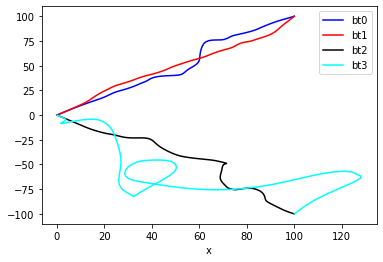

In [9]:
ax = base_trajs.loc[0].plot(x="x", y="y", label="bt0", c="b")
ax = base_trajs.loc[1].plot(x="x", y="y", label="bt1", c="r", ax=ax)
ax = base_trajs.loc[2].plot(x="x", y="y", label="bt2", c="k", ax=ax)
ax = base_trajs.loc[3].plot(x="x", y="y", label="bt3", c="cyan", ax=ax)

In [10]:
clustered_trajs = pd.concat(
    {
        m: pd.concat(
            {
                n: (
                    base_trajs.loc[m]
                    + create_smooth_traj(number_steps=100, smooth_length=21).mul(
                        create_sine_waves(inv_wave_number=1, number_steps=100),
                        axis=0
                    )
                )
                for n in range(10)
            },
        ) for m in base_trajs.index.levels[0]
    }, 
    names=["base traj", "cluster member",  "step"]
)

In [11]:
clustered_trajs

x           y
base traj cluster member step                        
0         0              0       0.000000    0.000000
                         1       1.010167    1.010278
                         2       2.021125    2.021264
                         3       3.035031    3.033301
                         4       4.055109    4.047934
...                                   ...         ...
3         9              95    120.032598  -77.257491
                         96    114.603662  -81.997729
                         97    109.204537  -87.439295
                         98    104.320178  -93.507210
                         99    100.000000 -100.000000

[4000 rows x 2 columns]

In [12]:
from matplotlib import pyplot as plt

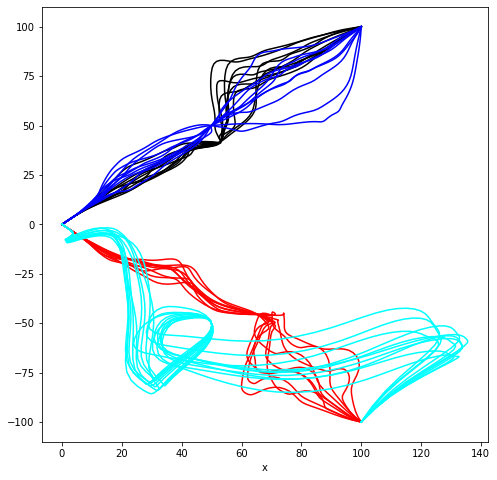

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = ["k", "b", "r", "cyan"]
for bt in clustered_trajs.index.get_level_values("base traj").unique():
    for tr in clustered_trajs.index.get_level_values("cluster member").unique():
        clustered_trajs.loc[bt, tr].plot(x="x", y="y", ax=ax, c=colors[bt], legend=False)

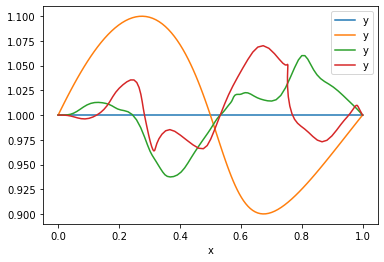

In [14]:
ax = create_traj_from_to(0, 1, 1, 1).plot(x="x", y="y");
(
    create_traj_from_to(0, 1, 1, 1)
    + 0.1 * create_traj_from_to(0, 1, 1, 1).mul(
        create_sine_waves(inv_wave_number=1),
        axis=0
    )
).plot(x="x", y="y", ax=ax);
(
    create_traj_from_to(0, 1, 1, 1).add(
        0.01 * create_smooth_traj().mul(
            create_sine_waves(inv_wave_number=1, stretch=1.1),
            axis=0
        ),
        axis=0
    )
).plot(x="x", y="y", ax=ax);
(
    create_traj_from_to(0, 1, 1, 1).add(
        0.01 * create_smooth_traj().mul(
            create_sine_waves(inv_wave_number=0.5, stretch=1.1),
            axis=0
        ),
        axis=0
    )
).plot(x="x", y="y", ax=ax);